### IMAGE COMPLETION

Image Completion is the task of filling missing parts of a given image with the help of information from the known parts of the image. This is an application that takes an image with a missing part as input and gives a completed image as the result.

We will be using Autoencoder to do this task. We will train our network on Images with missing parts passed with true images so that autoencoder can minimize the ture image and corrupted image. 

### Imports

In [ ]:
import os
import random
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape
from keras.layers import Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.utils import plot_model
from skimage.io import imread
from PIL import Image, ImageDraw

### Data

The data we are using is [Flickr-Faces-HQ Dataset (FFHQ)](https://github.com/NVlabs/ffhq-dataset). It is an unlabelled dataset used for training GANs and other image generation algorithms. The original dataset has images of size 1024 by 1024 but we have only taken 128 by 128 images. 

Mounting your google drive.

In [ ]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


Unzipping the data file to load it locally in the colab runtime. You can see your unzipped files by clicking the folder icon on left side of your colab.

In [ ]:
# replace this your google drive path of the zip file of dataset provided with this homework
!unzip -o -q "/drive/MyDrive/Dataset_assignment4/ffhq-dataset.zip" -d "/content/data/"
# !git clone https://github.com/NVlabs/ffhq-dataset.git

In [ ]:
# data folder path in colab runtime enviroment
DATA_FOLDER = '/content/data/'

# fetching all the filenmaes to read them later in generator
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.png')))

# total images in directory
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))
# print(filenames)

Total number of images : 70000


### Data Generator

The dataset is quite large (70000 images) which makes it impossible to load it all at the same time in computer memory. In you assignment 03 you implemented a custom generator function to load the images in batches, here we are going to do the same. Instead of returning the images and its labels, here we will return tuple <i>(corrupted_images_batch, original_images_batch)</i> from the generator where the corrupted images are the same images as the original but a small square is removed from them.

Below you will create a function to remove a portion of image. This is basically the same as drawing a black square on the image. You function will take a numpy image and return the numpy image with black square on it. 


You images will look somehting like this. The square drawn here is 28x28 (you can be confortable with the dimensions) and it is drawn at a random location with-in the image.

![picture](https://drive.google.com/uc?export=view&id=1qIlWIj1K_qjxoGTUJYeVbiLztnyMOVP_)


<i>HINT: You can use ImageDraw function of PIL</i>

In [ ]:
# image_path = filenames[1]
# image = cv2.imread(image_path)
# # plt.imshow(image)
# print(image.shape)
# rand_ = random.randint(0,120)
# print(rand_)

In [ ]:
def draw_square_on_image(image):
    
    output_img = image
    rand_ = random.randint(0,(image.shape[0]-28))
    output_img[rand_:rand_+28,rand_:rand_+28] = 0



    
    ######################## WRITE YOUR CODE BELOW ########################

    ########################### END OF YOUR CODE ##########################


    return np.array(output_img)

In [ ]:
# image = draw_square_on_image(image)
# plt.imshow(image)

If you are not fimiliar with generators in python you can a look at it [here](https://realpython.com/introduction-to-python-generators/).

As mentioned above, below generator will return a tuple of <i>(corrupted_images_batch, original_images_batch)</i>.

In [ ]:
def custom_image_generator(files, data_instances, batch_size = 16):

    ######################## WRITE YOUR CODE BELOW ########################

    # to keep track that you don't have invalid index for number of files
    iter = 0

    while True:

        # check if you have a invalid index for files, if yes then reset it
        if iter >= data_instances:
          iter = 0


        # Select files (paths/indices) for the batch
        # initializing original arrays and corrupted arrays
        batch_input = np.random.randn(batch_size,128,128,3)
        proc_batch = np.random.randn(batch_size,128,128,3)

        for x in range(0,batch_size):
          temp = cv2.imread(filenames[x])
          image = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)/255
          proc_batch[x] = image
          batch_input[x] = draw_square_on_image(image)

         
        # Read in each input and perform preprocessing (to batch of images)


        # Return a tuple of (corrupted_image_batch, true_image_batch) to feed the network
        corrupted_images_batch = np.array(batch_input)
        original_images_batch = np.array(proc_batch)

        # move to the next batch
        iter = iter + 1

    ########################### END OF YOUR CODE ##########################
    
        yield (corrupted_images_batch, original_images_batch)

Utility function to display grid of images.

In [ ]:
def display_image_grid(images, num_rows, num_cols, title_text):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        ax.imshow(im)
        ax.axis("off")
    
    plt.suptitle(title_text, fontsize=20)
    plt.show()

In [ ]:
# create generator object
test_generator = custom_image_generator(filenames, 7000)

Displaying sample images from batch generator.

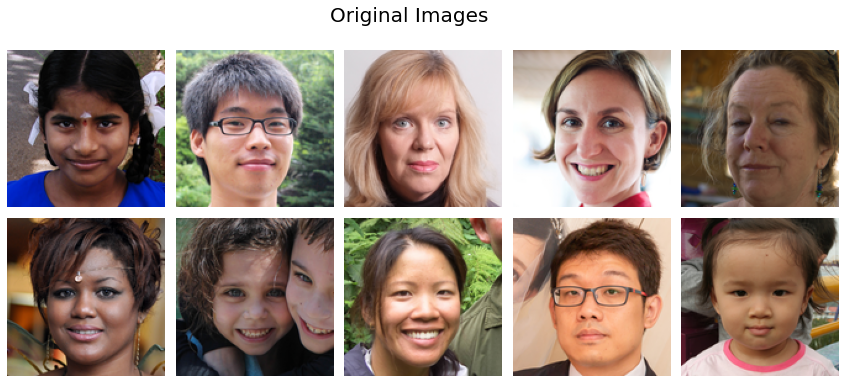

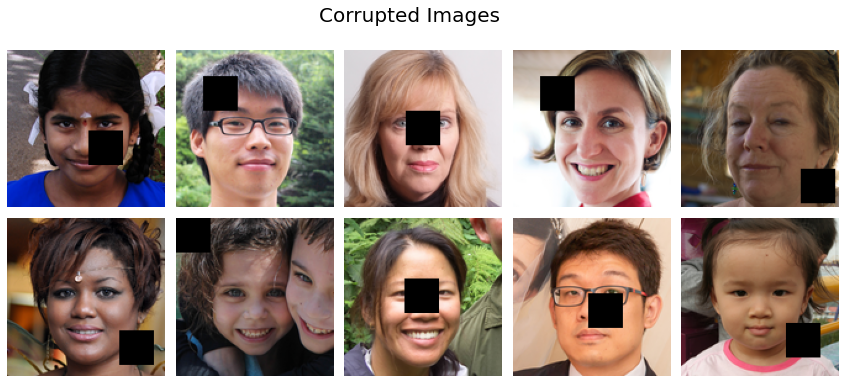

In [ ]:
# get first batch of images
(corrupted_images_batch, orig_images_batch) = next(test_generator)

# only displaying 10 images from both batch
display_image_grid(orig_images_batch[:10], 2, 5, "Original Images")
display_image_grid(corrupted_images_batch[:10], 2, 5, "Corrupted Images")

In [ ]:
INPUT_DIM = (128,128,3) # Image dimension
Z_DIM = 100             # Dimension of the latent vector (z)

## Building the Model

#### Encoder

Below you will create the model for the encoder. The architecture of the Encoder consists of a stack of convolutional layers followed by a dense (fully connected) layer which outputs a vector of size <b>Z_DIM</b>. The whole image of size 128x128x3 is decoed into this latent space vector of size <b>Z_DIM</b>.

for i=1 to num_conv:
  - add Covn Layer (filter_size = 32, stride = 2, padding = 'same')
  - add LeakeyReLU

end
- add Dense() (with no activation function)

NOTE: You can also experiment with the number of feature maps, kernel size and strides for each of the conv layer.

You can refer to this [link](https://blog.keras.io/building-autoencoders-in-keras.html) to see how to create autoencoer model in keras.

In [ ]:
# Code here
inputs = Input(shape=INPUT_DIM)


output = Conv2D(filters=256,kernel_size=3,padding="same",strides=2)(inputs)
output = BatchNormalization()(output)
output = LeakyReLU()(output)
output = Dropout(rate = 0.2)(output)


#         second layer
output = Conv2D(filters=128,kernel_size=3,padding = "same",strides=2)(output)
output = BatchNormalization()(output)
output = LeakyReLU()(output)
output = Dropout(rate = 0.2)(output)

#         third layer
output = Conv2D(filters=64,kernel_size=3,padding = "same",strides=2)(output)
output = BatchNormalization()(output)
output = LeakyReLU()(output)
output = Dropout(rate = 0.2)(output)

#         fourth layer
output = Conv2D(filters=32,kernel_size=3,padding = "same",strides=2)(output)
output = BatchNormalization()(output)
output = LeakyReLU()(output)
output = Dropout(rate = 0.2)(output)
output = Flatten()(output)
output = Dense(Z_DIM)(output)



ae_encoder = Model(inputs = inputs, outputs = output, name = "Encoder")

In [ ]:
ae_encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 256)       7168      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 256)       1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       295040    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512 

In [ ]:

# model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',   metrics=['accuracy'])

In [ ]:
# hist = model.fit(x = test_generator, epochs=10, verbose=2, steps_per_epoch=22)

In [ ]:
# ae_encoder = None
input1  = Input(Z_DIM)
temp = Dense(4*4*32)(input1)
output1 = Reshape((4,4,32))(temp)
output1  = Conv2DTranspose(filters=32,kernel_size=3,padding = "same",strides=2)(output1)
output1 = LeakyReLU()(output1)
output1  = Conv2DTranspose(filters=64,kernel_size=3,padding = "same",strides=2)(output1)
output1 = LeakyReLU()(output1)
output1  = Conv2DTranspose(filters=128,kernel_size=3,padding = "same",strides=2)(output1)
output = LeakyReLU()(output1)
output1  = Conv2DTranspose(filters=256,kernel_size=3,padding = "same",strides=2)(output1)
output1 = LeakyReLU()(output1)
output1  = Conv2DTranspose(filters=3,kernel_size=3,padding = "same",strides=2)(output1)
ae_decoder = Model(inputs = input1, outputs = output1, name = "Decoder")


######################## WRITE YOUR CODE BELOW ########################


########################### END OF YOUR CODE ##########################

ae_decoder.summary()
# tf.keras.utils.plot_model(ae_encoder, show_shapes=True)

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               51712     
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 32)          9248      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0   

#### Decoder

Just like the encoder you will create the model for the decoder. This model will be the exact mirror of encoder model, but that is not mandatory.

Since the function of the Decoder to reconstruct the image from the latent vector. Therefore, it is necessary to define the decoder so as to increase the size of the activations gradually through the network. This can be achieved through the  [Conv2DTransponse](https://keras.io/layers/convolutional/#conv2dtranspose) layer. This layer produces an output tensor double the size of the input tensor in both height and width. The input to the encoder is the vector of size <b>Z_DIM</b> and output will be a image of size <b>INPUT_DIM</b>. Your final decoder will look something like this: 

<center>

![picture](https://drive.google.com/uc?export=view&id=1QGaPm7byp7YOZqrZx9ARX9hPBVHB9rq5)

</center>

Again, you can experiment with the number of layers, feature size, kernel size and stride of conv layers.

<i>NOTE: Unlike the encoder, there will the activaiton function for decoder, as it will be outputing the image. And we want our pixel values between zero and one. </i>


In [ ]:
# ae_decoder = None
# ae_decoder_output = None

# ######################## WRITE YOUR CODE BELOW ########################


# ########################### END OF YOUR CODE ##########################

# ae_decoder.summary()
# # tf.keras.utils.plot_model(ae_decoder, show_shapes=True)

#### Attaching the Decoder to the Encoder

Finally, here we connect the encoder to the docoder.

In [ ]:

inputf = Input(shape=INPUT_DIM)
tempf = ae_encoder(inputf)
outputf = ae_decoder(tempf)
autoencoder_model = Model(inputs = inputf, outputs = outputf, name = "Autoencoder")

######################## WRITE YOUR CODE BELOW ########################

# The input of the autoencoder will be the same as of encoder


# The output of the autoencoder will be the output of decoder, when passed encoder input


# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.

########################### END OF YOUR CODE ##########################

autoencoder_model.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
Encoder (Functional)         (None, 100)               601284    
_________________________________________________________________
Decoder (Functional)         (None, 128, 128, 3)       455395    
Total params: 1,056,679
Trainable params: 1,055,719
Non-trainable params: 960
_________________________________________________________________


## Training the AE

Finally you will compile your autoencoer here. 

Here are few hyperparamters to consider here:
- Learning rate [0.1, 0.00001]
- Training epochs [5, 50]
- batch_size [64, 512]
- Latent vector size [20, 5000]
- Error function 
- Optimizer

In [ ]:
LEARNING_RATE = 0.0001   # learning rate
N_EPOCHS = 10         # epochs
BATCH_SIZE = 16      # batch of images returned by image generator

######################## WRITE YOUR CODE BELOW ########################

# create custom_data_generator here
train_generator = custom_image_generator(filenames, 7000)
val_data = custom_image_generator(filenames,100)


autoencoder_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),loss='mean_squared_error',   metrics=['accuracy'])
########################### END OF YOUR CODE ##########################

Now simply call the <i>fit</i> function of the model with the appropriate paramters.

<i> HINT: Pass step_per_epoch to be equal to total images divided by batch_size. As you want to see all your data in a single epoch. </i>

In [ ]:
SPE = NUM_IMAGES // BATCH_SIZE
print(SPE)

4375


In [ ]:
######################## WRITE YOUR CODE BELOW ########################
hist = autoencoder_model.fit(x = train_generator, epochs=N_EPOCHS, verbose=2, steps_per_epoch=SPE)
########################### END OF YOUR CODE ##########################

Epoch 1/10
4375/4375 - 414s - loss: 0.0101 - accuracy: 0.8399
Epoch 2/10
4375/4375 - 381s - loss: 0.0025 - accuracy: 0.8902
Epoch 3/10
4375/4375 - 383s - loss: 0.0014 - accuracy: 0.9015
Epoch 4/10
4375/4375 - 385s - loss: 0.0010 - accuracy: 0.9073
Epoch 5/10
4375/4375 - 388s - loss: 8.2542e-04 - accuracy: 0.9118
Epoch 6/10
4375/4375 - 389s - loss: 7.0156e-04 - accuracy: 0.9154
Epoch 7/10
4375/4375 - 384s - loss: 6.0784e-04 - accuracy: 0.9185
Epoch 8/10
4375/4375 - 381s - loss: 5.4387e-04 - accuracy: 0.9211
Epoch 9/10
4375/4375 - 381s - loss: 4.9548e-04 - accuracy: 0.9232
Epoch 10/10
4375/4375 - 379s - loss: 4.5868e-04 - accuracy: 0.9250


## Reconstruction

Now we will get a batch of images from data generator object and try to reproduce it by passing through AE.

The first image grid shows the original images and the second grid shows the reconstructed images after passing it through the AE.

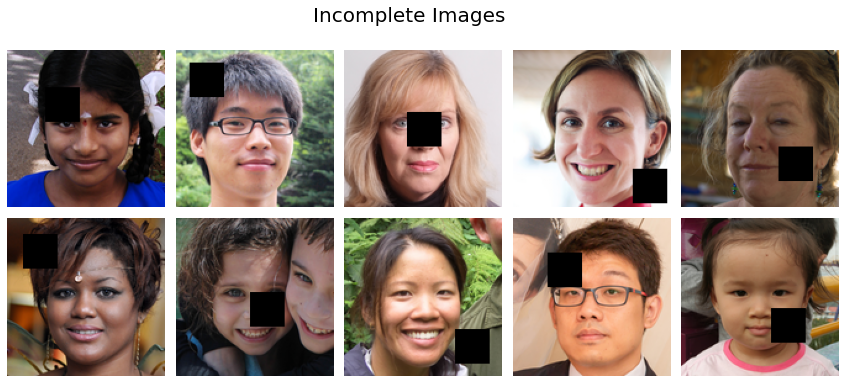

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

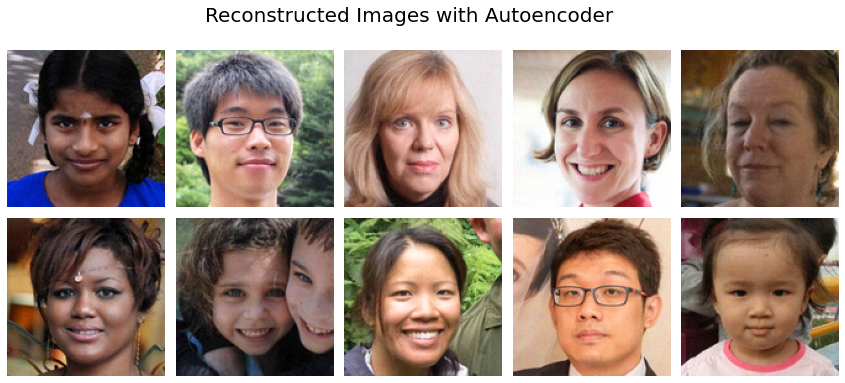

In [ ]:
test_gen = custom_image_generator(filenames, NUM_IMAGES)

test_batch = next(test_gen)[0]
test_images = test_batch[:10]

reconst_images = autoencoder_model.predict(test_images)

display_image_grid(test_images, 2, 5, "Incomplete Images")
display_image_grid(reconst_images, 2, 5, "Reconstructed Images with Autoencoder")

## REPORT

Report your results for different values of <b>Z_DIM</b>, <b>learning rate</b>, <b>optimizers</b>, <b> encoder and decoder model</b> and tell us for which configuration you acheived the best results (The best run model should be the last run model in this notebook, showing the results in the cell above).



```
# This is formatted as code
```

Your answer:Z_dim increased to accuracy and the training time was also reduced learning rate incrased the accuracy of my model , the model of encoder and decoder was the key factor and directly affected the loss and accuracy of the model.